In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Generate data

In [2]:
from read_results import read_varnames
import small_strato_f90.kpp4py as kpp4py

In [3]:
nvar = 5
varnames = read_varnames("small_strato_F90/small_strato_Parameters.f90")[0:nvar]
print(varnames)

['O1D', 'O', 'O3', 'NO', 'NO2']


In [4]:
df_range = (
    pd.read_csv('small_strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
O1D,1.000000e-08,1.550810e+02,7.754051e+01,1.550810e+02
O,1.000000e-08,1.040641e+09,5.203203e+08,1.040641e+09
O3,5.377002e+11,8.486620e+11,6.931811e+11,3.109618e+11
NO,1.000000e-08,9.433271e+08,4.716635e+08,9.433271e+08
NO2,1.531729e+08,1.096500e+09,6.248365e+08,9.433271e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


In [5]:
shrink = 0.0

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(5000, nvar+1))
y0_list.shape

(5000, 6)

In [6]:
%time y1_list = kpp4py.onestep(y0_list.T).T
y1_list.shape

CPU times: user 115 ms, sys: 1.94 ms, total: 117 ms
Wall time: 127 ms


(5000, 5)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:5])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:5]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 6)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([0.86905764, 0.87882359, 0.99404733, 1.25840389, 1.04451579])

# Examine data

## Distribution

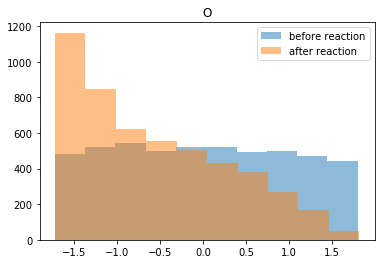

In [10]:
i = 1
plt.hist(X_train[:,i], alpha = 0.5, label='before reaction')
plt.hist(Y_train[:,i], alpha = 0.5, label='after reaction')
plt.title(varnames[i])
plt.legend()

# Fit ANN

In [11]:
x_torch = Variable(torch.from_numpy(X_train))
y_torch = Variable(torch.from_numpy(Y_train))

In [12]:
H1, H2 = 20, 20

model = torch.nn.Sequential(
    torch.nn.Linear(6, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    torch.nn.Linear(H2, 5)
).double()

In [13]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

20 3.844745545973434e-05
40 1.2291048503901285e-05
60 5.632014519558713e-06
80 3.7997971277695996e-06
100 2.9171533240710308e-06
120 2.676816896026208e-06
140 2.4762412648551525e-06
160 2.243782875040925e-06
180 1.8523378404208234e-06
200 1.8257256366680377e-06


In [14]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 6.6 ms, sys: 1.08 ms, total: 7.68 ms
Wall time: 3.67 ms


In [15]:
y_pred_numpy.shape

(5000, 5)

In [16]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99999754, 0.99999804, 0.99999877, 0.99999845, 0.99999808])

In [17]:
np.abs(y_pred_numpy/Y_train - 1).mean() # mean relative error

0.004485362239868537

# Test set

In [18]:
shrink = 0.0

y0_test =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(20000, nvar+1))

In [19]:
%time y1_test = kpp4py.onestep(y0_test.T).T

CPU times: user 640 ms, sys: 15.4 ms, total: 656 ms
Wall time: 431 ms


In [20]:
X_test = np.append(normalizer.transform(y0_test[:,0:5]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [21]:
Y_test.shape

(20000, 5)

In [22]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 27.2 ms, sys: 6.54 ms, total: 33.7 ms
Wall time: 20.4 ms


In [23]:
r2_score(y_test_pred, Y_test, multioutput='raw_values')

array([0.9999976 , 0.99999801, 0.99999866, 0.99999845, 0.99999791])

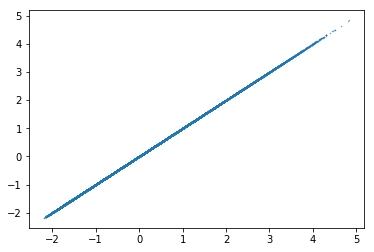

In [24]:
plt.scatter(y_test_pred, Y_test, s=0.1)

## Error distribution

In [25]:
abserr = np.abs(y_test_pred-Y_test) # absolute error
abserr.mean(), abserr.max()

(0.0009335256886684604, 0.022467761809408238)

(array([4.50938038e+02, 4.10766431e+01, 5.62022481e+00, 1.41005640e+00,
        5.75023001e-01, 1.40005600e-01, 1.20004800e-01, 4.00016001e-02,
        6.00024001e-02, 2.00008000e-02]),
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 ]),
 <a list of 10 Patch objects>)

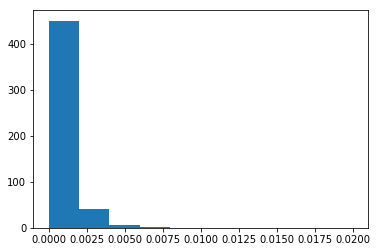

In [26]:
plt.hist(abserr.ravel(), normed=True, range=[0, 0.02])

In [27]:
relerr = np.abs(y_test_pred/Y_test - 1) # relative error
relerr.mean(), relerr.max()

(0.005760275803130042, 84.70350971156151)

(array([401.76075735,  55.68420623,  18.17374982,   9.10472732,
          5.2945137 ,   3.47356824,   2.34631628,   1.7648379 ,
          1.31087671,   1.08644645]),
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 ]),
 <a list of 10 Patch objects>)

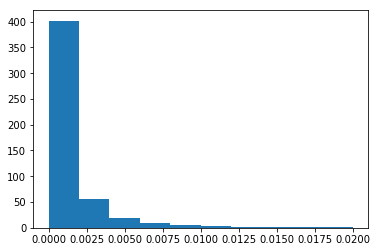

In [28]:
plt.hist(relerr.ravel(), normed=True, range=[0, 0.02])